In [1]:
# импорт нужных библиотек
import pandas as pd
from prophet import Prophet

In [2]:
# чтение файла
file = 'df4eda.csv'
df = pd.read_csv(file, index_col=0)

/tmp/ipykernel_514/2478625627.py:3: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, index_col=0)


In [3]:
# выберу нужные столбцы
df = df[['Date','Revenue_T']]

In [4]:
# проверю правильность типов
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Date       1048575 non-null  object 
 1   Revenue_T  1048534 non-null  float64
dtypes: float64(1), object(1)
memory usage: 24.0+ MB


In [5]:
# удаление дубликатов
df = df.drop_duplicates()

In [6]:
# АГРЕГАЦИЯ И ГРУППИРОВКА

#агрегация и суммирование по датам
agg_func_math = {
    'Revenue_T': ['sum']
}

# группирую по дате (месяц-год) и считаю статистические величины и все округляю до второго знака
df = df.groupby(['Date']).agg(agg_func_math).round(2).reset_index()

In [7]:
#проверяю, что с дуюликатами
duplicate_rows_df = df[df.duplicated()]
print(duplicate_rows_df)
print("number of duplicate rows: ", duplicate_rows_df.shape)

Empty DataFrame
Columns: [(Date, ), (Revenue_T, sum)]
Index: []
number of duplicate rows:  (0, 2)


In [8]:
# в новом датасете создам из названий мультииндексных родительских, объединяя через нижнее подчеркивание
df.columns = ['_'.join(col) for col in df.columns.values]

# сброшу индексы
df = df.reset_index()
df

index       Date_  Revenue_T_sum
0         0  2002-04-30      954560.88
1         1  2002-05-01      501617.97
2         2  2002-05-02      460054.35
3         3  2002-05-03      212396.94
4         4  2002-05-05      634911.48
...     ...         ...            ...
4475   4475  2014-12-26      894406.59
4476   4476  2014-12-27     1072392.93
4477   4477  2014-12-28     1174332.60
4478   4478  2014-12-29      420040.53
4479   4479  2014-12-30     1807761.69

[4480 rows x 3 columns]

In [9]:
# переименую колонку даты и колонку прибыли в требуемые для библиотеки названия
df = df.rename(columns={"Date_": "ds", "Revenue_T_sum": "y"})

# удалю лишний столбец index
df.drop(['index'], axis=1, inplace=True)

In [10]:
# создаю экземпляр класса анализатора временных рядов "Пророк"
m = Prophet()

# обучаю этот экземпляр на моей подготовленной выборке
m.fit(df)

18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# продолжаю датайрейм на год для прогнозирования
future = m.make_future_dataframe(periods=365)
future.tail()

ds
4840 2015-12-26
4841 2015-12-27
4842 2015-12-28
4843 2015-12-29
4844 2015-12-30

In [17]:
future

ds
0    2002-04-30
1    2002-05-01
2    2002-05-02
3    2002-05-03
4    2002-05-05
...         ...
4840 2015-12-26
4841 2015-12-27
4842 2015-12-28
4843 2015-12-29
4844 2015-12-30

[4845 rows x 1 columns]

In [12]:
# на обученной модели создаю прогноз на год 
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower    yhat_upper
4840 2015-12-26  747848.495322  345311.502832  1.178824e+06
4841 2015-12-27  747611.330025  338710.137735  1.143677e+06
4842 2015-12-28  668783.013400  261582.645460  1.067777e+06
4843 2015-12-29  689332.363625  304219.131318  1.083139e+06
4844 2015-12-30  873378.949226  478366.547715  1.258950e+06

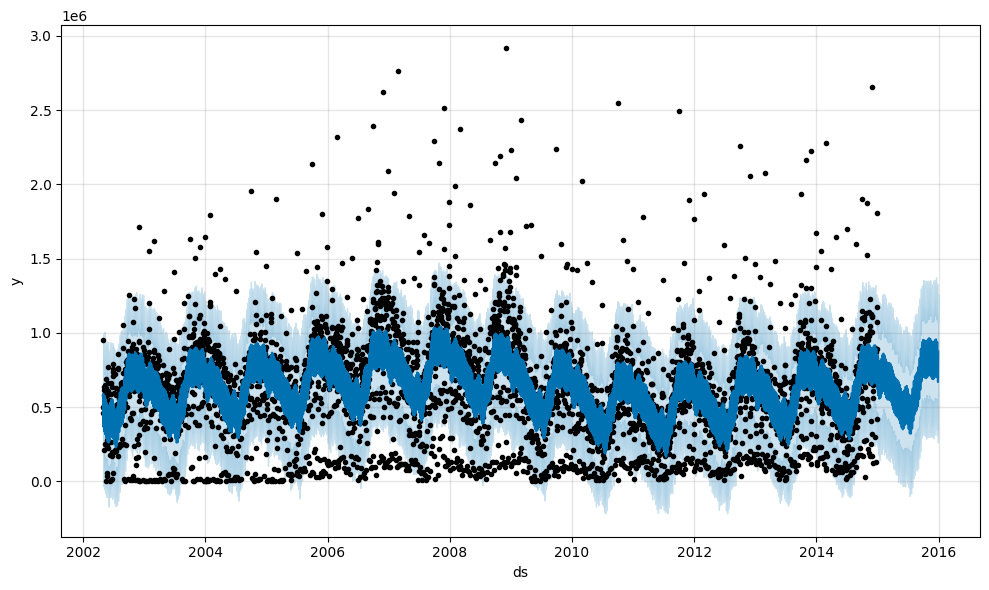

In [18]:
# строю график временного ряда по существующим годам и с прогнозом на год
fig1 = m.plot(forecast)

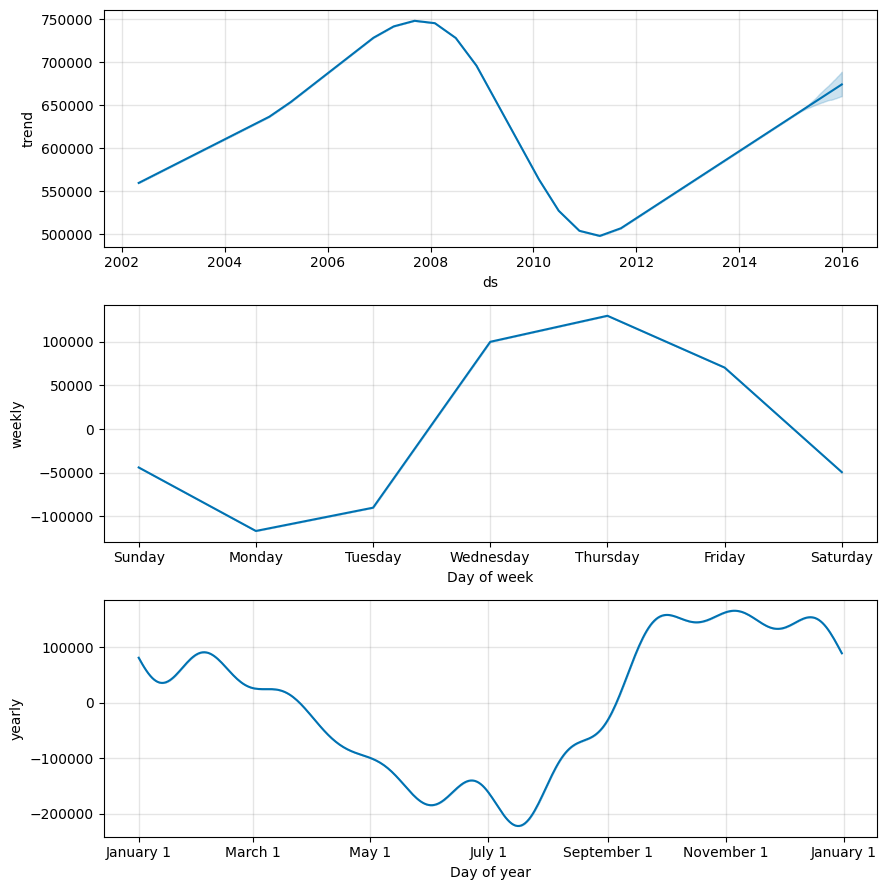

In [19]:
# смотрю составляющие: тренд, недельные колебания, годовые колебания
fig2 = m.plot_components(forecast)

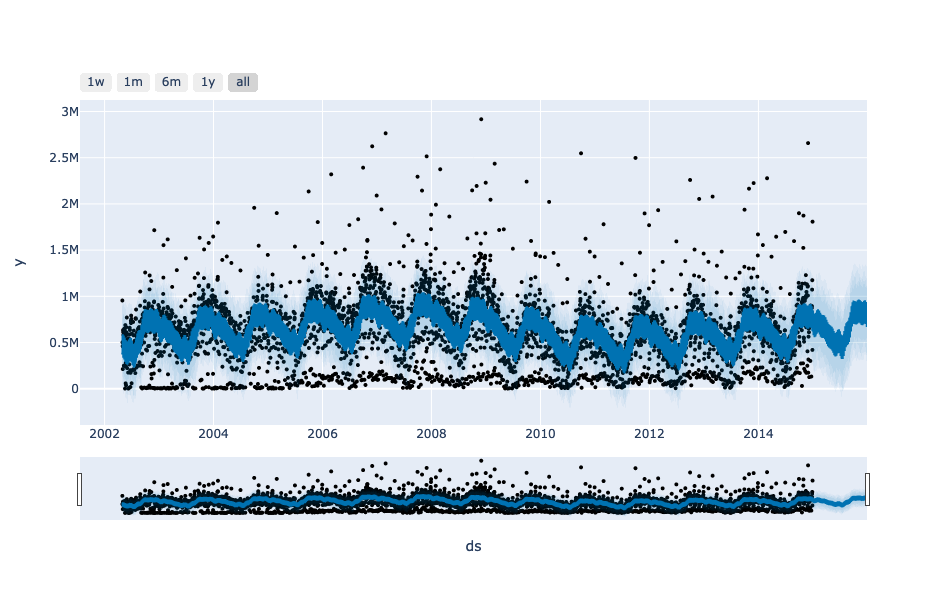

In [20]:
# тоже самое с более красивой визуализацией
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

/venv_neuroprophet/lib/python3.9/site-packages/plotly/io/_json.py:557: UserWarning:

Discarding nonzero nanoseconds in conversion.



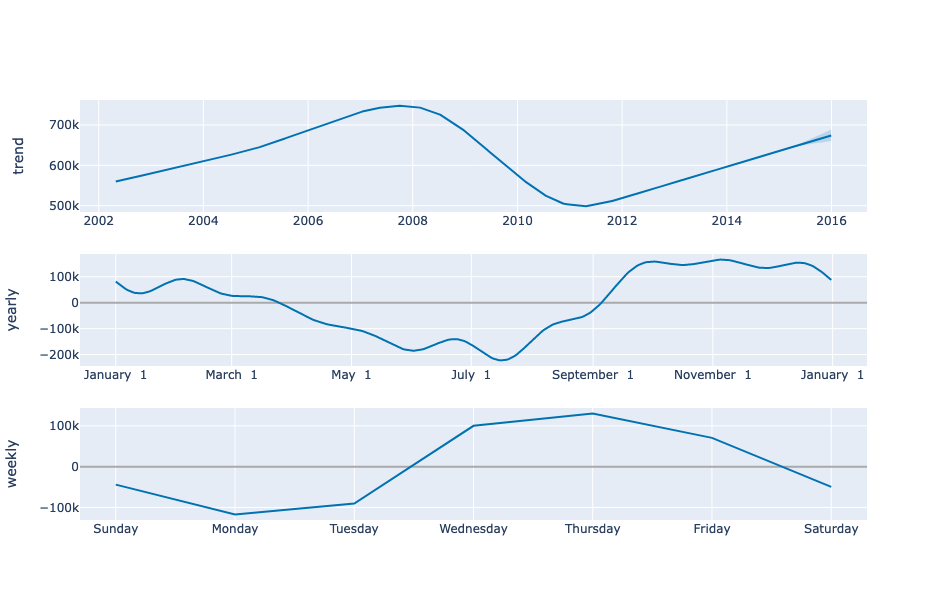

In [16]:
plot_components_plotly(m, forecast)